# IML - Model exploration

Model has to be a Convolutional Neural Network, consuming as input a spectrogram and performing a
classification task.

In [40]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import tensorflow as tf
from keras.api.utils import image_dataset_from_directory
import keras
from keras.api.layers import Dense
from keras.api import Model
import tensorboard
from datetime import datetime

### 1. Loading dataset

Use convenient function image_dataset_from_directory from keras. Handles train/validation split, 
shuffle, converting to grayscale etc.


In [19]:
image_size = (256, 256)
batch_size = 32

data_path = os.path.join(os.getcwd(), "..", "data", "overlap_000_res_256x256")
ds: tf.data.Dataset = image_dataset_from_directory(data_path, color_mode="grayscale", seed=42,
                                                   image_size=image_size, batch_size=batch_size,
                                                   subset="training", validation_split=0.2)

ds = ds.map(lambda X, y: (tf.cast(X, tf.float32), tf.cast(y, tf.float32)))

ds_size = int(ds.cardinality())
train_size = int(ds_size * 0.8)
valid_size = ds_size - train_size

train_ds = ds.take(train_size).prefetch(tf.data.AUTOTUNE)
valid_ds = ds.skip(train_size).prefetch(tf.data.AUTOTUNE)

Found 64368 files belonging to 2 classes.
Using 51495 files for training.


In [16]:
print(int(train_ds.cardinality()), int(valid_ds.cardinality()))

1288 322


### 2. Model

Time for fun :)

#### 1. Simple neural network

In [ ]:
def simple_nn(image_size=(256, 256)) -> Model:
    input_shape = (*image_size, 1)
    inputs = keras.Input(input_shape, dtype=np.float32)
    x = keras.layers.Rescaling(scale=1./255)(inputs)
    x = keras.layers.Flatten("channels_last")(x)
    x = Dense(256, activation="relu")(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=outputs, name="SimpleNN")
    return model


model = simple_nn()
model.summary()

Model: "SimpleNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,777,729 (64.00 MB)

 Trainable params: 16,777,729 (64.00 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Set up tensorboard
LOG_DIR = os.path.join(os.getcwd(), "..", "logs")
log_dir = os.path.join(LOG_DIR, "fit", datetime.now().strftime(f"%Y%m%d-%H%M%S-{model.name}"))
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True)

model.compile(optimizer="sgd", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(x=train_ds, validation_data=valid_ds,
          batch_size=batch_size, epochs=10,
          callbacks=[tensorboard_cb])

Epoch 1/10


1288/1288 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6914 - loss: 0.7021 - val_accuracy: 0.7197 - val_loss: 0.5016
Epoch 2/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.7232 - loss: 0.5273 - val_accuracy: 0.6872 - val_loss: 0.6640
Epoch 3/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.7424 - loss: 0.4926 - val_accuracy: 0.7135 - val_loss: 0.4823
Epoch 4/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.7858 - loss: 0.4368 - val_accuracy: 0.7293 - val_loss: 0.5765
Epoch 5/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.8098 - loss: 0.3998 - val_accuracy: 0.8289 - val_loss: 0.3522
Epoch 6/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.8270 - loss: 0.3706 - val_accuracy: 0.8820 - val_loss: 0.2930
Epoch 7/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.8383 - loss: 0.3498 - val_accuracy: 0.8874 - val_loss: 0.2597
Epoch 8/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.8503 - loss: 0.33

In [33]:
metrics = dict(zip(history.history.keys(), history.history.values()))

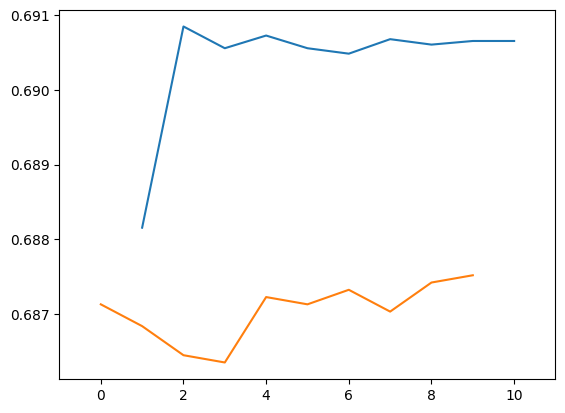

In [37]:
plt.plot(np.arange(10) + 1, metrics["accuracy"], metrics["val_accuracy"])
plt.xlim((-1, 11))
# plt.ylim((, 1.1))
plt.show()

### Sandbox

Blue channel is pretty useless - ~94% of it consists of 255 values.

0.9376254044222794


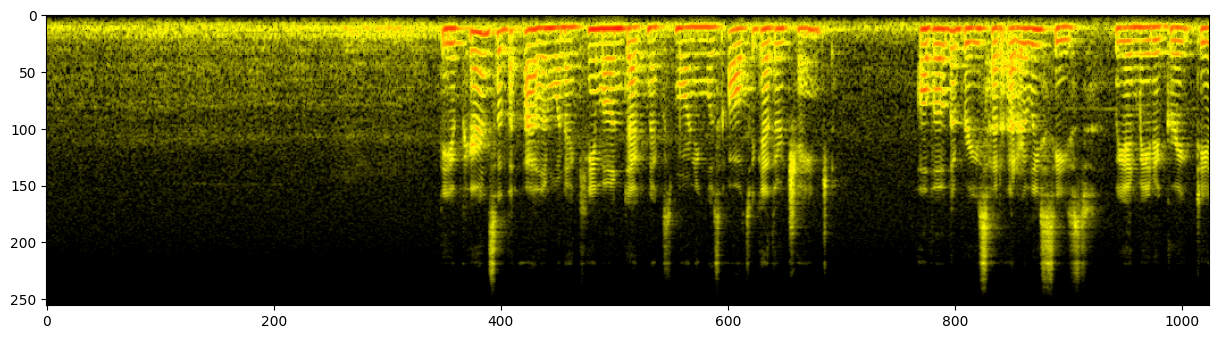

In [ ]:
# TODO: consider removing blue channel
print(np.sum(x[:,:,2] == 255)/len(x[:,:,2].reshape((-1))))

plt.figure(figsize=(15,15))
x2 = x.copy()
x2[:,:,2] = 0.0
plt.imshow(x2[:,:1024,:])
plt.show()

Visual check that splitting works (no duplicated/missing columns)

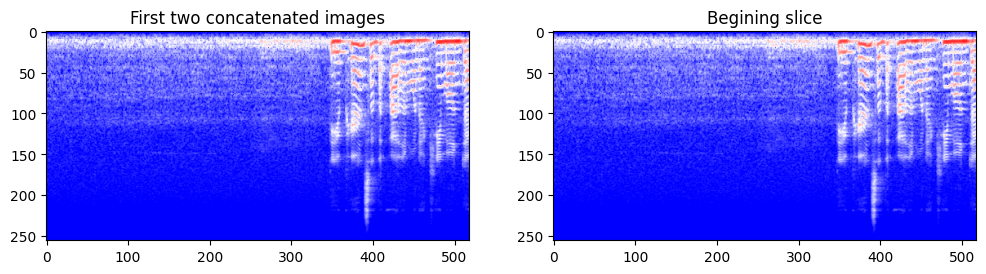

np.True_

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(12,12))
axs[0].imshow(np.concatenate(X[:2], axis=1))
axs[0].title.set_text("First two concatenated images")
axs[1].imshow(x[:, :target_width*2, :])
axs[1].title.set_text("Begining slice")
plt.show()

np.all(np.concatenate(X[:2], axis=1) == x[:, :target_width*2, :])

Shape: (256, 15847, 4)
Shape2: (33, 2048, 4)


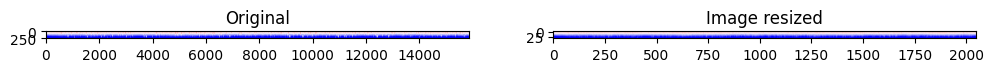

In [17]:
filepath = "/home/kaszkiet/projects/IML_Voice_Recognition/notebooks/../data/daps_img_overlap_0/1/f1_script2_ipad_balcony1_0.png"
img = PIL.Image.open(filepath)
x = np.array(img)
img.thumbnail((2048, 2048))
x2 = np.array(img)
print("Shape:", x.shape)
print("Shape2:", x2.shape)

fig, axs = plt.subplots(1, 2, figsize=(12,12))
axs[0].imshow(x)
axs[0].title.set_text("Original")
axs[1].imshow(x2)
axs[1].title.set_text("Image resized")
plt.show()

In [2]:
np.repeat(5, 10)

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [2]:
bytes = 128 * 256 * 4 * 64369
mb = bytes / 1000 / 1000
mb

8436.973568

In [12]:
0.8*0.8

0.6400000000000001